In [1]:
#!pip install langdetect
#!pip install scattertext
#!pip install spacy
#!pip install gensim
#!pip install pyLDAvis

In [1]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import scattertext as st
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
sw = stopwords.words("english")

## Load Data

In [3]:
df = pd.read_excel('./data/fake_job_postings.xlsx')

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


## Cleaning 
- Replace null to string "missing" -- instead of dropping missings, use as a valid observation. Could be that fake posts often have missing fields
- Separate country, state, city from location
- Drop non-english text entries
- Clean text columns: separate sentences, remove URLs, non-ascii, punctuation, extra spaces and white space
- Redefine education bins
- Drop salary range: very often missing, unsure what units are used in foreign countries, inconsistent time frame (hourly, monthly, yearly)

In [4]:
# replace null to "missing"
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [5]:
# separate location attributes
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [6]:
# drop non-english postings
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [9]:
# text cleaning 
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].apply(lambda x: re.sub(r'â€™', '', str(x))) # remove specific character used for apostrophe
                                                              # replace with '' before ascii removal so contractions together
    df[c] = df[c].str.replace('([A-Z])((?=[a-z]))', r' \1') # if lower case followed by upper case, separate by space
                                                            # works for a.A as well 
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) # empty strings mark as missing
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]','', x)) # remove punctuation. Replace with '' so don't separate contractions
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-9-1762eb734427>:12: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
<ipython-input-9-1762eb734427>:13: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs


In [ ]:
# spot cleanup for nyc abbreviations
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

# spot cleanup experience
df.required_experience = np.where(df.required_experience == 'not applicable', 'missing', df.required_experience)

In [10]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [11]:
# drop salary range variable 
del df['salary_range']

## EDA

In [12]:
df.fraudulent = pd.to_numeric(df.fraudulent)

__Data Distributions__    
If lots of values, plot both head and tail to get sense of range

In [13]:
def hist_plt(col, title, boolean = False, tail = False):
    
    if tail:
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        num = 10
    else:
        f, ax1 = plt.subplots()
        num = 1000
        
    head = df[col].value_counts().head(num)
    
    if boolean == False:
        ax1.bar(head.index, head)
        ax1.set_xticklabels(labels = head.index, rotation=90)
    else:
        bplt = df[col].value_counts()
        bplt = bplt.sort_index() # need to be in No, Yes order
        ax1.bar(bplt.index, bplt)
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(labels = ['No', 'Yes'])
    
    if tail:
        tail = df[col].value_counts().tail(10)
        ax2.bar(tail.index, tail)
        ax2.set_xticklabels(labels = tail.index, rotation=90)
        
    f.suptitle(title, fontsize=16)
    
    return ax1.get_figure()

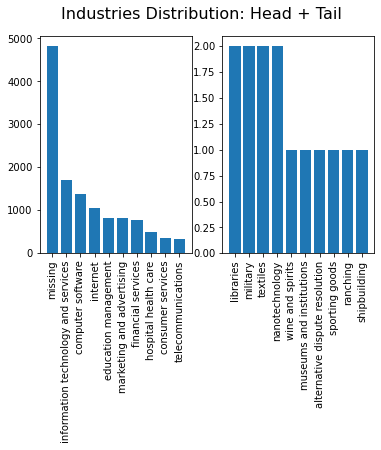

In [14]:
ind_dist = hist_plt('industry', 'Industries Distribution: Head + Tail', tail = True)

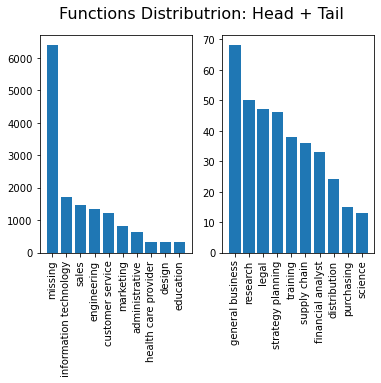

In [15]:
fun_dist = hist_plt('function', 'Functions Distributrion: Head + Tail', tail = True)

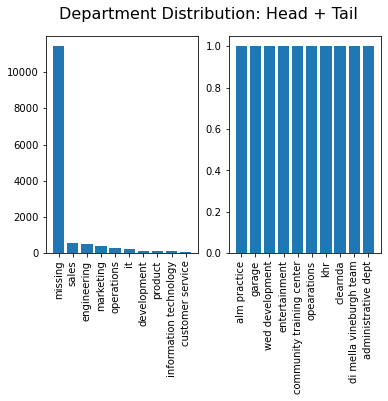

In [16]:
dep_dist = hist_plt('department', 'Department Distribution: Head + Tail', tail = True)

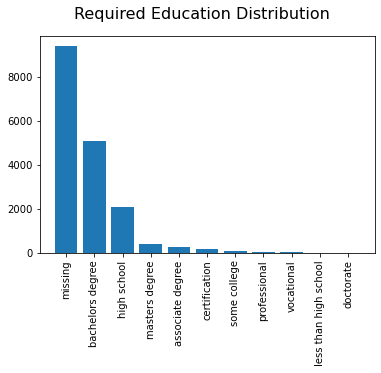

In [17]:
edu_dist = hist_plt('education_bin', 'Required Education Distribution')

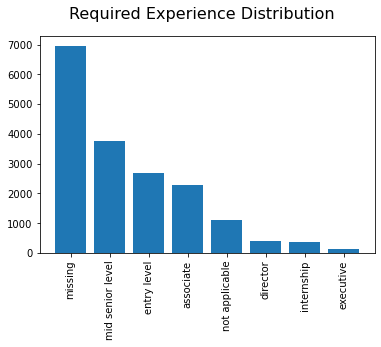

In [18]:
exp_dist = hist_plt('required_experience', 'Required Experience Distribution')

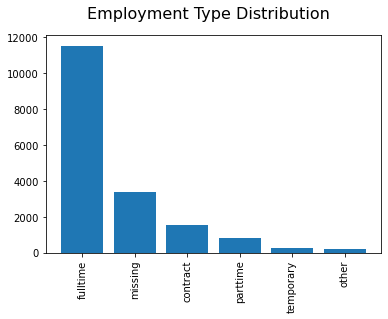

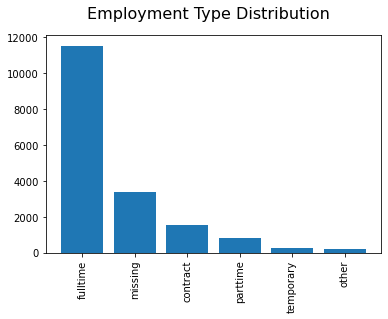

In [19]:
hist_plt('employment_type', 'Employment Type Distribution')

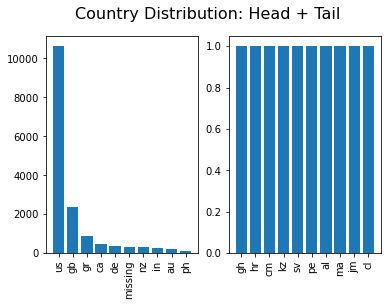

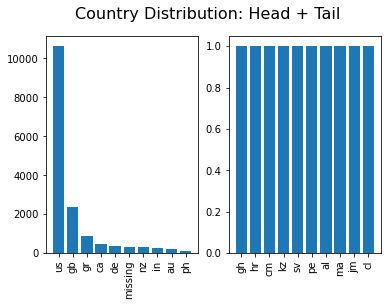

In [20]:
hist_plt('country', 'Country Distribution: Head + Tail', tail = True)

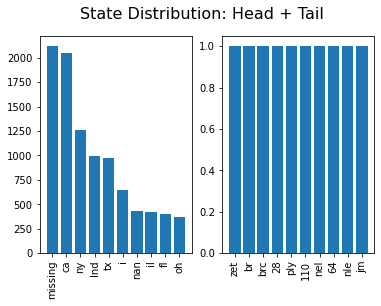

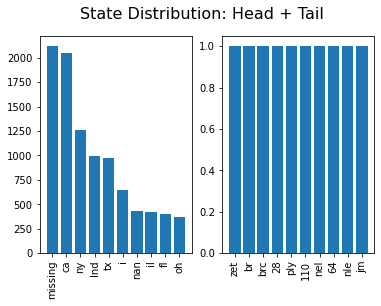

In [21]:
hist_plt('state', 'State Distribution: Head + Tail', tail = True)

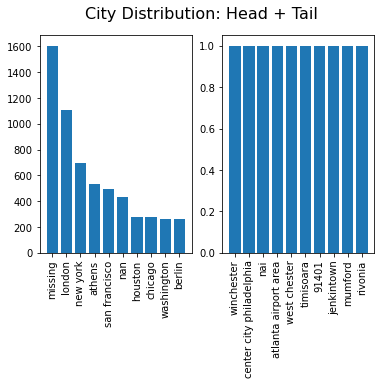

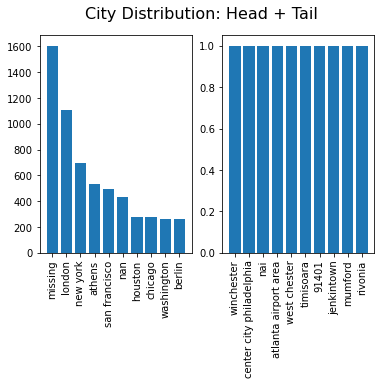

In [22]:
hist_plt('city', 'City Distribution: Head + Tail', tail = True)

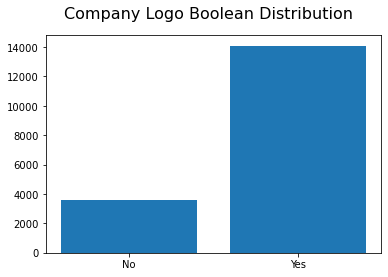

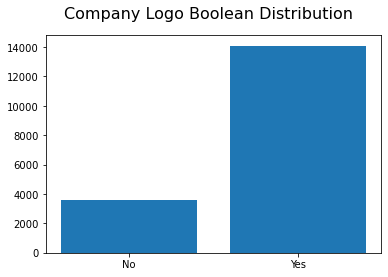

In [23]:
hist_plt('has_company_logo', 'Company Logo Boolean Distribution', boolean = True)

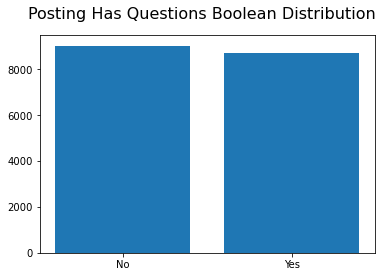

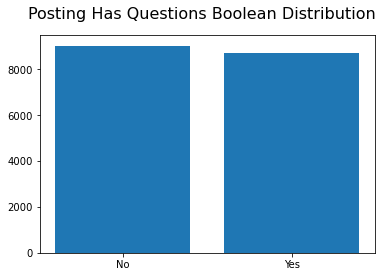

In [24]:
hist_plt('has_questions', 'Posting Has Questions Boolean Distribution', boolean = True)

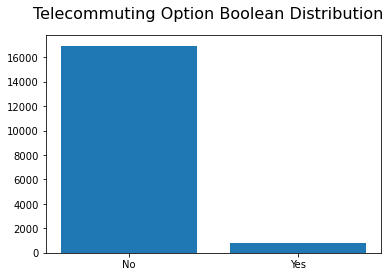

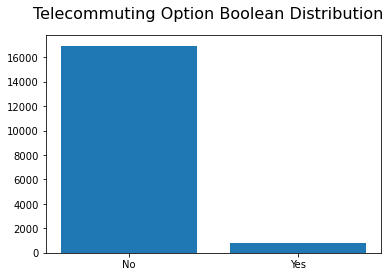

In [25]:
hist_plt('telecommuting', 'Telecommuting Option Boolean Distribution', boolean = True)

__Bar Plots of Metadata Frequency in Fraudulent Posts__

In [26]:
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame()
    totcnt = df.groupby(col).job_id.count().to_frame()
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True)
    frac['frac'] = frac.fraudulent / frac.job_id 
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort and take top 10 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

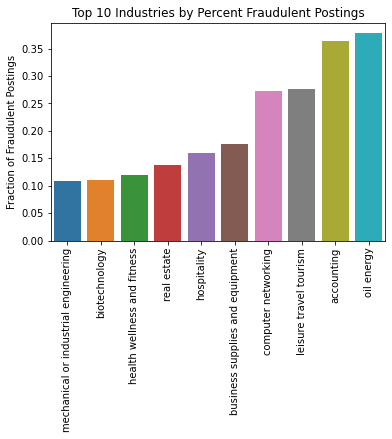

In [27]:
bar_plt('industry', 'Industries')

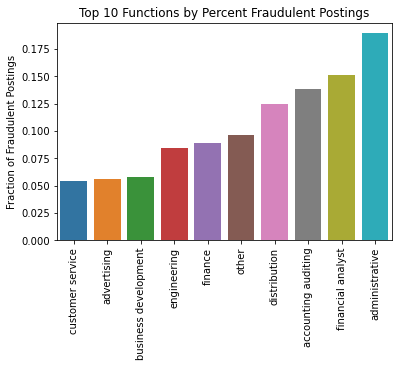

In [28]:
bar_plt('function', 'Functions')

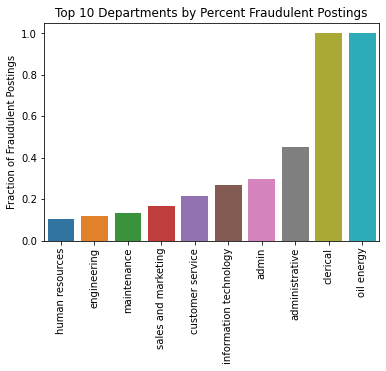

In [29]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

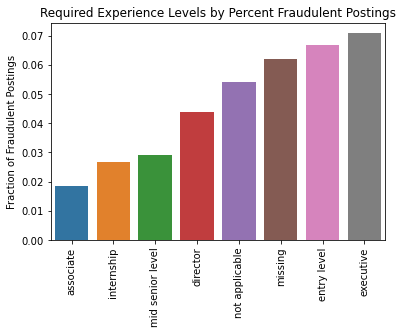

In [30]:
bar_plt('required_experience', 'Required Experience Levels')

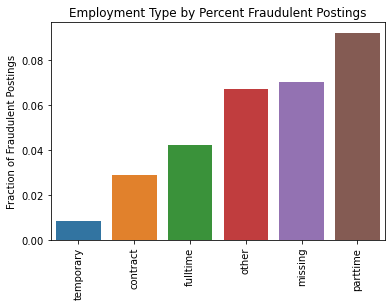

In [31]:
bar_plt('employment_type', 'Employment Type')

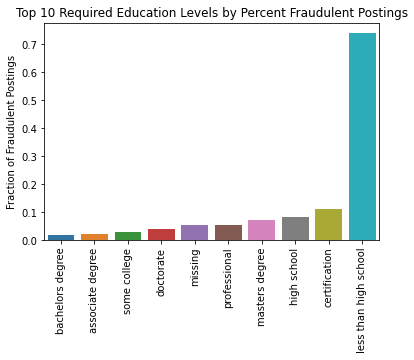

In [32]:
bar_plt('education_bin', 'Required Education Levels')

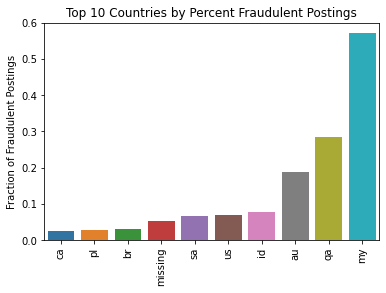

In [33]:
bar_plt('country', 'Countries')

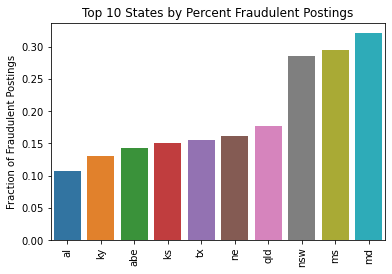

In [34]:
bar_plt('state', 'States')

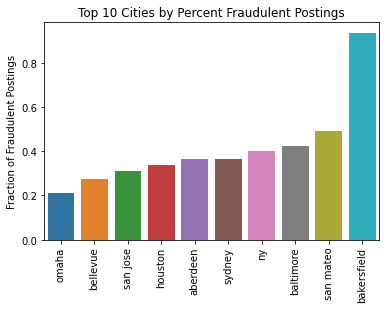

In [35]:
bar_plt('city', 'Cities')

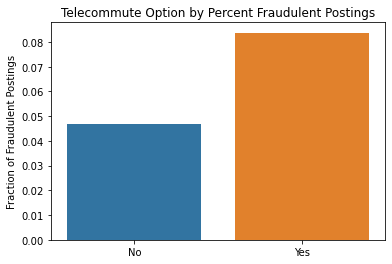

In [36]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

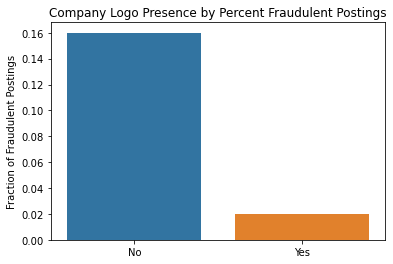

In [37]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

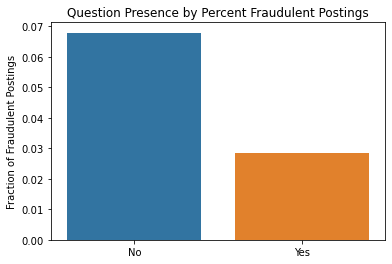

In [38]:
bar_plt('has_questions', 'Question Presence', boolean = True)

__Visualize Common Words in Fake vs Real Postings using Scattertext__   
Tokenize and remove stop words. Don't bother with lemmatization for exploratory analysis + interferes with ability to see examples using scattertext interactive html

In [39]:
nlp = spacy.load('en')

In [40]:
# run in terminal (with admina priviledges): 'py -m spacy download en'
#nltk.download('stopwords')

In [41]:
df['fraudulent_words'] = np.where(df.fraudulent == 1, 'fake', 'real')

In [42]:
# combine text fields into single string 
for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
    df[c] = np.where(df[c] == 'missing', '', df[c])
    
df['text'] = (df.title + ' ' + df.company_profile + ' ' + df.description + ' ' + df.requirements + ' ' + df.benefits + ' ' +
              df.industry + ' ' + df.function)
# don't include location (country, state, city) here because will be excluded in lemmatization (proper noun)
# use as metadata

In [43]:
def scattertext_visualize(col):
    
    df['parse'] = df[col].apply(st.whitespace_nlp_with_sentences)
    
    corpus = st.CorpusFromParsedDocuments(
        df, category_col='fraudulent_words', parsed_col='parse'
    ).build().get_unigram_corpus().compact(st.AssociationCompactor(2000)).remove_terms(sw, ignore_absences=True)

    html = st.produce_scattertext_explorer(
        corpus,
        category='fake', category_name='Fraudulent', not_category_name='Real',
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank,
        metadata=corpus.get_df()['title']
    )
    open('./scattertext_' + col + '.html', 'w').write(html)

In [44]:
scattertext_visualize('text')

In [45]:
nlp_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for c in nlp_columns:
    scattertext_visualize(c)

## Topic Modeling
Sections of code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling

- Combine text fields into single string
- Tokenize, remove stop words, lemmatize based on POS 
- Build term frequency corpus
- Build LDA Model
    - Tune based on topic coherence. Specificall C_V coherence
    
Topic coherence: Degree of semantic similarity between high scoring words in the topic    
Modern alternative to perplexity: how suprised a model is by new data (normalized log likelihood of held out test set)    
CV_coherence: "C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity"       
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0   
  
Parameters:
- Number of Topics
- Alpha
- Eta
    - Selecting alpha and eta with built in auto method which learns an asymetric prior from the data
     
From https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/: (assuming symmetric data)
"alpha represents document-topic density - with a higher alpha, documents are made up of more topics, and with lower alpha, documents contain fewer topics. Beta represents topic-word density - with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words"

In [46]:
# function from
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [47]:
# tokenize
df.text = df.text.apply(lambda row: row.split(' '))
# remove stop words
df.text = df.text.apply(lambda row: [w for w in row if w not in sw])

# convert into list 
text = df.text.values.tolist()

# lemmatize and remove proper nouns 
# ex removing company names. Not important for topic modeling. 
text = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [48]:
# save text string (10 minutes to run tokenization through lemmatization process)
with open('textlst.pkl', 'wb') as f:
    pickle.dump(text, f)

In [49]:
with open('textlst.pkl', 'rb') as f:
    text = pickle.load(f)

In [50]:
# term document frequency corpus for LDA
corpus_dict = corpora.Dictionary(text)
corpus = [corpus_dict.doc2bow(t) for t in text]

In [51]:
#[[(corpus_dict[id], freq) for id, freq in cp] for cp in corpus[:2]]  - human readable format

In [52]:
# tune LDA model based on topic coherence values (maximize)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=corpus_dict,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta = 'auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [53]:
model_list, coherence_values = compute_coherence_values(dictionary=corpus_dict, corpus=corpus, texts=text, 
                                                        start=2, limit=20, step=1)
# 2.5 hours to run

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [54]:
np.argmax(coherence_values) # started at 2, this is position 13, so 15 topics

13

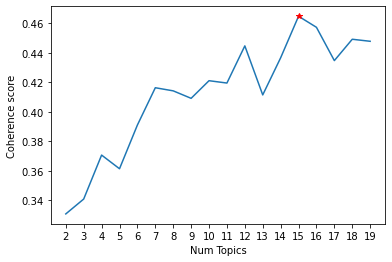

In [55]:
limit=20; start=2; step=1; 
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(range(2, 20))
plt.plot(np.argmax(coherence_values) + 2, coherence_values[np.argmax(coherence_values)], 'r*')

In [56]:
with open('model_list.pkl', 'wb') as f:
    pickle.dump(model_list, f)
    
with open('coherence_values.pkl', 'wb') as f:
    pickle.dump(coherence_values, f)

In [57]:
with open('model_list.pkl', 'rb') as f:
    model_list = pickle.load(f)
    
with open('coherence_values.pkl', 'rb') as f:
    coherence_values = pickle.load(f)

In [58]:
lda_model_best = model_list[np.argmax(coherence_values)]

In [59]:
# visualize topics - still don't look separate, even if they are coherent. investigate other ways to tune. 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_best, corpus, corpus_dict)
pyLDAvis.save_html(vis, 'topic_vis.html')

In [60]:
# reconstruct dataframe with metadata columns with topic probabilities 
topicdf = pd.DataFrame()
for i in range(0, np.argmax(coherence_values)+2):
    topicdf['topic' + str(i)] = 0
    
for i, row in enumerate(lda_model_best[corpus]):
    s = pd.Series(dtype = float)
    
    for j in row[0]:
        s['topic' + str(j[0])] = j[1] 
    topicdf = topicdf.append(s, ignore_index = True)

In [61]:
# merge
df = df.reset_index(drop = True)
df = pd.merge(df, topicdf, how = 'left', left_index = True, right_index = True)
# replace missings with 0s 
topic_cols = [c for c in df.columns if c.startswith('topic')]
for c in topic_cols:
    df[c] = np.where(df[c].isnull(), 0, df[c])

In [62]:
# save final dataframe ready for classification 
with open('finaldf.pkl', 'wb') as f:
    pickle.dump(df, f)

In [104]:
with open('finaldf.pkl', 'rb') as f:
    df = pickle.load(f)

## Classification

### Dummy Variables

In [105]:
# convert telecommuting, has_questions, has_company_logo to numeric
for c in ['telecommuting', 'has_questions', 'has_company_logo']:
    df[c] = pd.to_numeric(df[c])

In [106]:
for c in ['employment_type', 'required_experience', 'education_bin', 'country']:
    
    # many values for country, only create dummy if more than 100 job postings in that country
    if c == 'country':
        cnts = df.country.value_counts()
        cnts = cnts[cnts > 100]   
        df.country = np.where(df.country.isin(cnts.index), df.country, 'other')
    
    # create dummies 
    prefix = c
    dum = pd.get_dummies(df[c], prefix = c)
    df = df.join(dum)
    
# remove columns not needed for modeling
df_mod = df.drop(columns = ['employment_type', 'required_experience','required_education', 'education_bin', 'country',
                            'location', 'title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 
                            'industry', 'function', 'state', 'city', 'language', 'fraudulent_words', 'job_id', 'text', 'parse'])

# remove one level from dummies to prevent collinearity for regression
df_reg = df_mod.drop(columns = ['employment_type_missing', 'required_experience_missing', 'education_bin_missing',
                                'country_missing'])

### SMOTE: class imbalance
Would also like to explore weighting within the regression (ie LogisticRegression(class_weight = 'balanced')), but cannot easily do grid search for parameters with weighting - no package. Thus using SMOTE instead for MVP version

In [66]:
# code adapted from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

def smote(df_reg):

    # X and Y data frames
    X = df_reg.loc[:, df_reg.columns != 'fraudulent']
    y = df_reg.loc[:, df_reg.columns == 'fraudulent']

    # oversample setup
    os = SMOTE(random_state=0)

    # test-train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # oversample training data 
    columns = X_train.columns
    os_data_X,os_data_y=os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['fraudulent'])

    # check the numbers of our data
    print("Original number of fraudulent in data is", len(y_train[y_train.fraudulent == 1]))
    print("length of oversampled data is ",len(os_data_X))
    print("Number of real in oversampled data",len(os_data_y[os_data_y['fraudulent']==0]))
    print("Number of fraudulent",len(os_data_y[os_data_y['fraudulent']==1]))
    print("Proportion of real data in oversampled data is ",len(os_data_y[os_data_y['fraudulent']==0])/len(os_data_X))
    print("Proportion of fraudulent data in oversampled data is ",len(os_data_y[os_data_y['fraudulent']==1])/len(os_data_X))
    
    return X_train, X_test, y_train, y_test, os_data_X, os_data_y

### Set up Evaluation Functions

In [67]:
def model_predict(model, logistic = True):
    # predict
    predict = model.predict(X_test.values)

    # dataframe from true values
    true_df = pd.DataFrame(y_test.fraudulent.to_list())

    # predict probabilities rather than class
    prob = model.predict_proba(X_test.values) 
    prob_df = pd.DataFrame(prob)
    
    if logistic:
        # get coefficients
        coef_dict = {}
        for coef, feat in zip(model.coef_[0,:], X_train.columns):
            coef_dict[feat] = coef

    # create dataframe from real and fake 
    predict_df = pd.DataFrame(predict)
    predict_df = pd.merge(true_df, predict_df, left_index = True, right_index = True)
    predict_df.columns = ['truth', 'predict']

    if logistic:
        return predict, prob, predict_df, true_df, prob_df, coef_dict
    else:
        return predict, prob, predict_df, true_df, prob_df

In [68]:
def metrics_print(predict_df, predict):
    # accuracy 
    accuracy = len(predict_df[predict_df.truth == predict_df.predict]) / len(predict_df)
    print('Accuracy:', accuracy)

    # true positive rate: predict fraudulent when actually fraudulent (recall)
    tpr = len(predict_df[(predict_df.truth == predict_df.predict) & (predict_df.truth == 1)]
             ) / len(predict_df[predict_df.truth == 1])
    print('TPR/recall:', tpr)

    # true negative rate: predict real when actually real
    tnr = len(predict_df[(predict_df.truth == predict_df.predict) & (predict_df.truth == 0)]
             ) / len(predict_df[predict_df.truth == 0])
    print('TNR:', tnr)

    # false positive rate: predict fraudulent when actually real (companies upset)
    fpr = len(predict_df[(predict_df.predict == 1) & (predict_df.truth == 0)]) / len(predict_df[predict_df.truth == 0])
    print('FPR:', fpr)

    # false negative rate: predict real when actually fake (job seekers upset) (1-recall)
    fnr = len(predict_df[(predict_df.predict == 0) & (predict_df.truth == 1)]) / len(predict_df[predict_df.truth == 1])
    print('FNR:', fnr)
    
    # precision: positive predictive value aka when predict fake, get it right (actually fake)
    try:
        precision = len(predict_df[(predict_df.truth == predict_df.predict) & (predict_df.truth == 1)]
                   ) / len(predict_df[predict_df.predict == 1])
        print('Precision:', precision)
    except ZeroDivisionError:
        precision = 0
        print('Precision: No fake predictions')
        
    # curve areas
    roc = roc_auc_score(y_test.fraudulent.to_list(), predict)
    pr = average_precision_score(y_test.fraudulent.to_list(), predict)
    print('Area under ROC:', roc)
    print("Area Under PR:", pr)
    
    return [accuracy, tpr, tnr, fpr, fnr, precision, roc, pr]

### Unregularized Logistic Regression

In [69]:
X_train, X_test, y_train, y_test, os_data_X, os_data_y = smote(df_reg)

ValueError: setting an array element with a sequence.

In [ ]:
# imbalanced data 
lr_imb = LogisticRegression(random_state = 1, solver = 'saga', fit_intercept = False
                             ).fit(X_train, y_train.fraudulent.to_list())

In [ ]:
predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(lr_imb) 
metrics_print(predict_df, predict)
# very bad recall and ROC (random guessing). Good accuracy. Rarely predict the fake class. 

In [ ]:
# balanced class weighting
lr = LogisticRegression(class_weight = 'balanced',  random_state = 1, solver = 'saga', fit_intercept = False
                             ).fit(X_train, y_train.fraudulent.to_list())

In [ ]:
predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(lr)
metrics_print(predict_df, predict)

In [ ]:
# SMOTE 
lr_smote = LogisticRegression(random_state = 1, solver = 'saga', fit_intercept = False
                             ).fit(os_data_X, os_data_y.fraudulent.to_list())

In [ ]:
predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(lr_smote)
metrics_print(predict_df, predict)

### Lasso CV
- No need to scale or normalize since all features are categorical or probabilities between 0 and 1    
- refit =  true means will refit with the best selected parameters after CV       
- Fit without intercept so can include all topic levels (which sum to 1). Still need to remove 1 level from the other dummies.       
- Increasing max_iter even to 5000 does not get rid of convergence warning

Iterations: repeat the following each with these 4 scoring metrics: roc auc, accuracy, precision, recall
1. Balanced weighting
    - class_weigthing = 'balanced'
    - penalty = 'l1' 
    - fit(X_train, y_train)
2. SMOTE 
    - penalty = 'l1'
    - fit(os_data_X, os_data_y)
3. SMOTE with elastic net penalty
    - SMOTE better than balanced weighting so keep with that
    - penalty = 'elasticnet'
    - l1_ratios = [0, .25, .5, .75, 1]
    - fit(os_data_X, os_data_y)
    
__Best: SMOTE with Area Under ROC and l1 penalty__

In [ ]:
def logistic_iteration(x, y, penalty, l1_ratios, weighting, filename):

    lrcv_roc = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'roc_auc', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_acc = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'accuracy', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_prec = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'precision', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_rec = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'recall', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    
    model_list = [lrcv_roc, lrcv_acc, lrcv_prec, lrcv_rec]
    
    # save model list
    with open(filename + '.pkl', 'wb') as f:
        pickle.dump(model_list, f)

In [ ]:
# balanced weighting
logistic_iteration(X_train, y_train, 'l1', None, 'balanced', 'lasso_list_scoring')

In [ ]:
# SMOTE 
logistic_iteration(os_data_X, os_data_y, 'elasticnet', [0, 0.25, 0.5, 0.75, 1], None, 'lasso_list_scoring_smote')

In [ ]:
# elastic net with smote
logistic_iteration(os_data_X, os_data_y, 'l1', None, None, 'lasso_list_scoring_smote_elasticnet') 

In [ ]:
#sorted(sklearn.metrics.SCORERS.keys()) scoring metrics. try roc_auc, average_precision, average roc

In [ ]:
with open('lasso_list_scoring.pkl', 'rb') as f:
    model_list = pickle.load(f)
with open('lasso_list_scoring_smote.pkl', 'rb') as f:
    model_list_smote = pickle.load(f)
with open('lasso_list_scoring_smote_elasticnet.pkl', 'rb') as f:
    model_list_en = pickle.load(f)

In [ ]:
# class weighting
stats = []
for i in model_list:
    print(str(i))
    predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(i)
    stats.append(metrics_print(predict_df, predict))
    
# recall does the best at minimizing FNR (as is its purpose) and everything else is just slightly worse
# accuracy still doesn't predict any fake even with class weighting

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins], 15, weights=[stats[0][:-1], stats[1][:-1], stats[2][:-1], stats[3][:-1]], 
            histtype='bar', label=['ROC', 'Accuracy', 'Precision', 'Recall'])
plt.legend()

# accuracy FPR = 0, FNR = 1. Almost always predicts real. 
# either ROC or precision the best balanced. Depends on FNR, FPR tradeoff

In [ ]:
stats_smote = []
for i in model_list_smote:
    print(str(i))
    predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(i)
    #print(coef_dict)
    stats_smote.append(metrics_print(predict_df, predict))
    
# accuracy, recall all the same. ROC best. Precision bad for TPR. accuracy/recall, roc very similar. 
# better than balanced weighting in general
# precision gives better accuracy but very bad TPR and FNR

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins], 15, weights=[stats_smote[0][:-1], stats_smote[1][:-1], stats_smote[2][:-1], stats_smote[3][:-1]], 
            histtype='bar', label=['ROC', 'Accuracy', 'Precision', 'Recall'])
plt.legend()

# ROC, accuracy, recall all very similar 

In [ ]:
stats_en = []
for i in model_list_en:
    print(str(i))
    predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(i)
    stats_en.append(metrics_print(predict_df, predict))
    
# not materially different from smote without elastic net

__SMOTE vs class imbalance__

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins], 15, weights=[stats[0][:-1], stats_smote[1][:-1]], 
            histtype='bar', label=['Class Weighting: ROC', 'SMOTE: ROC'])
plt.legend()

# SMOTE overall a bit better. Better in several categories and only tiny bit worse in the ones its worse in
# better at balancing between metrics

__Select Best Model: SMOTE ROC__

In [ ]:
best_model = model_list_smote[0]
predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(best_model)

In [ ]:
metrics_print(predict_df, predict)

In [ ]:
coef_dict # not shrinking any coefficients to zero

__Examine Different Thresholds__         
Changes are pretty small. I think keep with .5?

In [ ]:
threshold_list = [0.4, 0.45, 0.5, 0.55, 0.6]
for i in threshold_list: 
    pred_thresh = prob_df.applymap(lambda x: 1 if x>i else 0)
    pred_thresh = pd.merge(pred_thresh, true_df, left_index = True, right_index = True)
    pred_thresh.columns = ['', 'predict', 'truth']
    
    print(i)
    metrics_print(pred_thresh, predict)

__Graph ROC Curve__        
0.5 threshold does a good job of getting to the closest to the upper left corner

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test.fraudulent.to_list(), prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) # why is this different from above calculation?
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# find 0.5 threshold 
threshold5 = np.argmin([abs(i-0.5) for i in threshold]) # value closet to 0.5 in threshold list
plt.vlines(x = fpr[threshold5], ymin = 0, ymax = 1)
plt.hlines(y = tpr[threshold5], xmin = 0, xmax = 1)

plt.show()

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_test.fraudulent.to_list(), prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) # why is this different from above calculation?
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# find 0.5 threshold 
threshold5 = np.argmin([abs(i-0.5) for i in threshold]) # value closet to 0.5 in threshold list
plt.vlines(x = fpr[threshold5], ymin = 0, ymax = 1)
plt.hlines(y = tpr[threshold5], xmin = 0, xmax = 1)

plt.show()

__Merge Predictions with Full Test Data__

In [ ]:
# original data before column dropping: limit to test indicies
df_test = df[df.index.isin(y_test.index.to_list())]
# need to sort in same order as test data so can merge with predictions
y_test['order'] = 1 # record order (cumulative sum)
y_test.order = y_test.order.cumsum()
del y_test['fraudulent']
df_test = pd.merge(df_test, y_test, left_index = True, right_index = True) # merge on index
df_test = df_test.sort_values('order') # resort by original test order

In [ ]:
# merge with predictions
df_test = df_test.reset_index(drop = True)
pred_full = pd.merge(df_test, predict_df, left_index = True, right_index = True)

## Ensemble Tree Models
Code modified from 
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ and https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [ ]:
X_train, X_test, y_train, y_test, os_data_X, os_data_y = smote(df_mod) 
# don't need to drop one level of dummies in this case so use df_mod, not df_reg

__Default Results__    
Results with all default values. SMOTE data    
Error due to printing, model still trains correclty

In [ ]:
# unbalanced
xgb = XGBClassifier(objective = 'binary:logistic')
xgb.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb, logistic = False)
metrics_print(predict_df, predict)
# precision very good but recall and ROC poor

In [ ]:
# SMOTE
xgb = XGBClassifier(objective = 'binary:logistic')
xgb.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb, logistic = False)
metrics_print(predict_df, predict)
# recall better but still not great. Only getting 50% of thefake posts. 

In [ ]:
# class balanced weighting
# calculate balance weight ratio 
scale_weight = len(y_train[y_train.fraudulent == 0]) / len(y_train[y_train.fraudulent == 1])

xgb = XGBClassifier(objective = 'binary:logistic', scale_pos_weight = scale_weight)
xgb.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb, logistic = False)
metrics_print(predict_df, predict)
# poor precision, best recall and ROC out of the 3 

In [ ]:
# feature importance (ex SMOTE)
cols = pd.Series(os_data_X.columns).to_frame()
fimport = pd.Series(xgb.feature_importances_).to_frame()

fimport = pd.merge(cols, fimport, left_index = True, right_index = True)
fimport.columns = ['col', 'import']
fimport = fimport.sort_values('import', ascending = False)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.bar(fimport.col, height = fimport['import'])
plt.xticks(rotation=90)

__Parameter Tuning__    
Ideally would do full grid search with all parameters, but resource needs too much so doing sequential tuning instead   
Tune most parameters with high learning rate and low number of estimators.          

In [ ]:
# for tuning, use fewer trees and higher learning rate
# afterwards, will increase trees and reduce learning rate
# takes around 5 hours to run
def xgb_tune(score, x, y, scale_pos_weight = 1):
    
    print('start')

    # max depth and min child weight
    xgb1 = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.3, n_estimators = 100, 
                         scale_pos_weight = scale_pos_weight)
    param_grid = dict(max_depth = range(3, 12, 1), min_child_weight = range(1, 6, 1))
    grid = GridSearchCV(estimator =xgb1, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    max_depth = grid_result.best_params_['max_depth']
    min_child_weight = grid_result.best_params_['min_child_weight']
    
    # gamma - minimum loss reduction required for a tree split
    xgb2 = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.3, n_estimators=100, max_depth = max_depth, 
                         min_child_weight = min_child_weight, scale_pos_weight = scale_pos_weight)
    param_grid = dict(gamma = [i/10 for i in range(0, 5)])
    grid = GridSearchCV(estimator = xgb2, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
    
    gamma = grid_result.best_params_['gamma']
    
    # subsample and colsample_bytree
    xgb3 = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.3, n_estimators=100, max_depth = max_depth,
                         min_child_weight = min_child_weight, gamma = gamma, scale_pos_weight = scale_pos_weight)
    param_grid = dict(subsample = [i/10 for i in range(6,11)], colsample_bytree = [i/10 for i in range(6,11)])
    grid = GridSearchCV(estimator = xgb3, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
    
    subsample = grid_result.best_params_['subsample']
    colsample_bytree= grid_result.best_params_['colsample_bytree']
    
    # regularization alpha and lambda
    xgb4 = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.3, n_estimators=100, max_depth = max_depth, 
                         min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                         colsample_bytree = colsample_bytree, scale_pos_weight = scale_pos_weight)
    param_grid = dict(reg_alpha = [0, 0.001, 0.005, 0.01, 0.05], reg_lambda = [1, 0.95, 0.9, 0.85, 0.8])
    grid = GridSearchCV(estimator = xgb4, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
    
    reg_alpha = grid_result.best_params_['reg_alpha']
    reg_lambda = grid_result.best_params_['reg_lambda']
    
    # learning rate and n estimators. Add early stopping rounds to help with train speed
    xgb5 = XGBClassifier(objective = 'binary:logistic',  max_depth = max_depth, 
                         min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                         colsample_bytree = colsample_bytree, reg_alpha = reg_alpha, reg_lambda = reg_lambda,
                        early_stopping_rounds = 30, scale_pos_weight = scale_pos_weight)
    param_grid = dict(learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3], n_estimators = [100, 500, 1000])
    grid = GridSearchCV(estimator = xgb5, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 

_SMOTE_   
Very overfit. Ex: ROC on training CV 0.998, on testing 0.75    
Very good at minimizing FPR. But TPR very low. Don't predict fake when it's real, but have a hard time catching all the fakes. 

In [ ]:
xgb_tune('roc_auc', x = os_data_X, y = os_data_y) 

In [ ]:
xgb_roc = XGBClassifier(objective = 'binary:logistic', max_depth = 10, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 0.8, subsample = 1, reg_alpha = 0.001, reg_lambda = 1, 
                          learning_rate = 0.05, n_estimators = 500)
xgb_roc.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_roc, logistic = False)
stats_roc = metrics_print(predict_df, predict)

In [ ]:
xgb_tune('precision', x = os_data_X, y = os_data_y)  

In [ ]:
xgb_prec = XGBClassifier(objective = 'binary:logistic', max_depth = 11, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 0.6, subsample = 0.9, reg_alpha = 0.05, reg_lambda = 0.85, 
                          learning_rate = 0.05, n_estimators = 1000)
xgb_prec.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_prec, logistic = False)
stats_prec = metrics_print(predict_df, predict)

In [ ]:
xgb_tune('recall', x = os_data_X, y = os_data_y)  

In [ ]:
xgb_rec = XGBClassifier(objective = 'binary:logistic', max_depth = 9, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 1.0, subsample = 0.9, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.3, n_estimators = 100)
xgb_rec.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_rec, logistic = False)
stats_rec = metrics_print(predict_df, predict)

In [ ]:
xgb_tune('accuracy',  x = os_data_X, y = os_data_y)  

In [ ]:
xgb_acc = XGBClassifier(objective = 'binary:logistic', max_depth = 11, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 0.6, subsample = 1.0, reg_alpha = 0, reg_lambda = 0.8, 
                          learning_rate = 0.3, n_estimators = 100)
xgb_acc.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_acc, logistic = False)
stats_acc = metrics_print(predict_df, predict)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins], 15, weights=[stats_roc[:-1], stats_prec[:-1], stats_rec[:-1], stats_acc[:-1]], 
            histtype='bar', label=['ROC', 'Precision', 'Recall', 'Accuracy'])
plt.legend()
# all very similar. 

_Balanced Weighting_   
Overfitting is better. Ex 0.92 on train CV, 0.9 on test for ROC    
Better balance between weighting

In [ ]:
xgb_tune('roc_auc', x = X_train, y = y_train, scale_pos_weight = scale_weight) 

In [ ]:
xgb_roc_bal = XGBClassifier(objective = 'binary:logistic', max_depth = 7, min_child_weight = 2, gamma = 0.3, 
                          colsample_bytree = 1.0, subsample = 1, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.3, n_estimators = 100, scale_pos_weight = scale_weight)
xgb_roc_bal.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_roc_bal, logistic = False)
stats_roc_bal = metrics_print(predict_df, predict)

In [ ]:
is the fraction of relevant instances among the retrieved instances
# fraction of fake that we are getting 

In [ ]:
xgb_tune('precision', x = X_train, y = y_train, scale_pos_weight = scale_weight) 

In [ ]:
xgb_prec_bal = XGBClassifier(objective = 'binary:logistic', max_depth = 10, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 0.6, subsample = 1.0, reg_alpha = 0.05, reg_lambda = 0.8, 
                          learning_rate = 0.1, n_estimators = 500, scale_pos_weight = scale_weight)
xgb_prec_bal.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_prec_bal, logistic = False)
stats_prec_bal = metrics_print(predict_df, predict)
# predict all real posts correct, but less good at predicting fake than other metrics
# is this in line with precision?

In [ ]:
xgb_tune('recall', x = X_train, y = y_train, scale_pos_weight = scale_weight) 

In [ ]:
xgb_rec_bal = XGBClassifier(objective = 'binary:logistic', max_depth = 3, min_child_weight = 5, gamma = 0.4, 
                          colsample_bytree = 0.7, subsample = 0.8, reg_alpha = 0.005, reg_lambda = 1, 
                          learning_rate = 0.01, n_estimators = 500, scale_pos_weight = scale_weight)
xgb_rec_bal.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_rec_bal, logistic = False)
stats_rec_bal = metrics_print(predict_df, predict)

In [ ]:
xgb_tune('accuracy',  x = X_train, y = y_train, scale_pos_weight = scale_weight) 

In [ ]:
xgb_acc_bal = XGBClassifier(objective = 'binary:logistic', max_depth = 10, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 0.6, subsample = 1.0, reg_alpha = 0.01, reg_lambda = 0.85, 
                          learning_rate = 0.05, n_estimators = 1000, scale_pos_weight = scale_weight)
xgb_acc_bal.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_acc_bal, logistic = False)
stats_acc_bal = metrics_print(predict_df, predict)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins], 15, weights=[stats_roc_bal[:-1], stats_prec_bal[:-1], 
                                                stats_rec_bal[:-1], stats_acc_bal[:-1]], 
            histtype='bar', label=['ROC', 'Precision', 'Recall', 'Accuracy'])
plt.legend()
# recall very different. Much higher TPR and FPR. Lower FNR but lower precision. Highest ROC. 
# decrease in FNR is worth the increase in FPR. Precision isn't great though. 

__Compare class imbalance vs SMOTE__    
Class imbalance recall vs SMOTE ROC

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins], 15, weights=[stats_roc[:-1], stats_rec_bal[:-1], stats_roc_bal[:-1]], 
            histtype='bar', label=['SMOTE: ROC','Class Weighting: Recall', 'Class Weighting: ROC'])
plt.legend()
# SMOTE and class weighting ROCs very similar
# class weighting recall better TPR, FNR. Worse precision, FPR. Somewhat worse TNR, accuracy 
# go towards class weighting since SMOTE so overfit

In [ ]:
# feature importance for class weighting recall
cols = pd.Series(X_train.columns).to_frame()
fimport = pd.Series(xgb_rec_bal.feature_importances_).to_frame()

fimport = pd.merge(cols, fimport, left_index = True, right_index = True)
fimport.columns = ['col', 'import']
fimport = fimport.sort_values('import', ascending = False)
fimport = fimport[fimport['import'] > 0]

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(fimport.col, height = fimport['import'])
plt.xticks(rotation=90)

In [ ]:
# feature importance for class weighting ROC
cols = pd.Series(X_train.columns).to_frame()
fimport = pd.Series(xgb_roc_bal.feature_importances_).to_frame()

fimport = pd.merge(cols, fimport, left_index = True, right_index = True)
fimport.columns = ['col', 'import']
fimport = fimport.sort_values('import', ascending = False)
fimport = fimport[fimport['import'] > 0]

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(fimport.col, height = fimport['import'])
plt.xticks(rotation=90)

__Compare xgboost and logistic__

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins], 15, weights=[stats_roc_bal[:-1], stats_rec_bal[:-1], stats_smote[1][:-1]], 
            histtype='bar', label=['XGBoost (Weight, ROC)', 'XGBoost (Weight, Recall)', 'Logistic (SMOTE, ROC)'])
plt.legend()

# XGBoost overall better for accuracy, TNR, precision, FPR. Worse for TPR and FNR.